In [18]:
import numpy as np
from collections import defaultdict
from math import sqrt, pi, exp
import matplotlib.pyplot as plot

In [21]:
# data = np.genfromtxt("seeds_dataset.txt")
data = np.genfromtxt("data_banknote_authentication.txt", delimiter=",")

np.random.shuffle(data)

In [4]:
def k_fold_cross_val(array, k):
  """
  Input:
  -----
  1- array: the numpy array that needs to be split
  2- k:     the number of partitions to make of "array"
  
  Returns:
  --------
  A dictionary with two keys, "sets" and "folds". The sets key points at
  a list containing k partitions of the passed array. The folds key points
  at a list of length k containing pairs where each pair indicates the indices
  of partitions from "sets" which correspond to the training and testing data.
  e.g ( [1, 2, 3, 4], 0). Here, the list tells us that the partitions 1-4 from
  "sets" will be used for training and partition 0 will be used for testing.
  
  """
  result = {}
  result["sets"] = np.array_split(array, k)
  
  folds = []
  for i in range(0, k):
    folds.append( (np.arange(0, k)[np.arange(0, k) != i], i) )
  
  result["folds"] = folds
  return result
  

In [5]:
def get_class_information(array):
  """
  Returns all the classes and their probabilities in the given array. Assumes
  last column of the given array contains the class label.
  
  """
  temp = np.unique(array[:, -1], return_counts=True)
  classes = temp[0]
  class_probs = temp[1] / np.sum(temp[1])
  
  return classes, class_probs


In [6]:
def get_norm_params(classes, array):
  """
  Computes mean and stdev for all features of each class and returns it in the
  form of a nested dictionary. To get mean of e.g. class=3 and feature=2, we will do
  dict[3][2]["mean"]. For standard deviation, simply replace "mean" with "std".
  
  """
  norm_params = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
  
  for class_ in classes:
    for feature in range(0, array.shape[1] - 1):
        feature_data = array[:, feature][array[:, -1] == class_]
      
        mean = np.mean(feature_data)
        std = np.std(feature_data)

        norm_params[class_][feature]["mean"] = mean
        norm_params[class_][feature]["std"] = std
      
  return norm_params

In [7]:
def get_norm_prob(mean, std, x):
  """
  Returns probability of x in a normal distribution.
  
  """
  return 1 / ( std * sqrt(2 * pi) ) * exp( (-(x - mean) **2 ) / (2 * std**2 ) )

In [8]:
def get_cond_prob(x, class_, norm_params):
  """
  Computes the conditional probability part of the Bayes Theorem which is 
  the product of the normal dist. probability for each feature of the given
  datapoint, x, for the given class.
  
  """
  prob = 1
  
  for feature in range(0, x.shape[0] - 1):
    mean = norm_params[class_][feature]["mean"]
    std = norm_params[class_][feature]["std"]
    
    prob *= (get_norm_prob(mean, std, x[feature]))
    
  return prob

In [9]:
def naive_bayes(train, test):
  """
  Returns the accuracy of the Bayes Classifier on the given test set after
  training on the train set.
  
  """
  classes, class_probs = get_class_information(train)           
  norm_params = get_norm_params(classes, train)
  
  correct_guesses = 0
  
  for datapoint in test:
    # Contains the probability of datapoint belonging to each class
    prediction_probs = []

    for index, class_ in enumerate(classes):
      prediction_probs.append( class_probs[index] * get_cond_prob(datapoint, class_, norm_params) )
    
    # Compare class corresponding to the max probability with actual class  
    if classes[prediction_probs.index(max(prediction_probs))] == datapoint[-1]:
      correct_guesses += 1

  return correct_guesses / test.shape[0]

(array([1, 2, 3, 4]), 0)   0.8545454545454545
(array([0, 2, 3, 4]), 1)   0.8472727272727273
(array([0, 1, 3, 4]), 2)   0.8248175182481752
(array([0, 1, 2, 4]), 3)   0.8357664233576643
(array([0, 1, 2, 3]), 4)   0.8321167883211679


{'whiskers': [<matplotlib.lines.Line2D at 0x4789ff0>,
 'caps': [<matplotlib.lines.Line2D at 0x47c4650>,
 'boxes': [<matplotlib.lines.Line2D at 0x4789f30>],
 'medians': [<matplotlib.lines.Line2D at 0x47c4b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x47c4e90>],
 'means': [<matplotlib.lines.Line2D at 0x47c4d90>]}

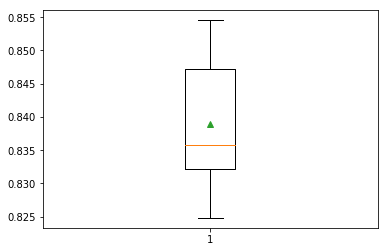

In [22]:
split_data_dict = k_fold_cross_val(data, k = 5)
sets = split_data_dict["sets"]
folds = split_data_dict["folds"]

accuracies = []

# fold -> tuple(list of indexes of training sets in "sets", index of test set in "sets")
for fold in folds:
  
  # Use first set as initial set so concatenate can be called as dimensions of 
  # both arrays need to be same for concat to work.
  final_train_set = sets[fold[0][0]]
  
  for training_set in fold[0][1:]:
    final_train_set = np.concatenate([final_train_set, sets[training_set]])
    
  accuracies.append(naive_bayes(final_train_set, sets[fold[1]]))
  print (fold, " ", naive_bayes(final_train_set, sets[fold[1]]))
  
plot.boxplot(accuracies, showmeans=True)